In [1]:
!pip install pandas scikit-learn

In [2]:
from include.graficos import *
from include.utils import *
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

**1. Definição do Problema de Negócios**

**Contexto do Problema:**

O contexto do problema é a construção de um modelo preditivo para prever os custos médicos individuais cobrados pelo seguro de saúde.
Isso envolve analisar um conjunto de dados que contém informações sobre características individuais, como idade, gênero, IMC (índice de massa corporal), número de filhos, fumante ou não, região, entre outros, e os custos médicos correspondentes.

**Objetivos da Análise:**

- Considerar na escolha do modelo aquele que entregar a melhor acurácia.
- Desenvolver um modelo preditivo que possa fazer previsões confiáveis dos custos médicos individuais com base nas características fornecidas.
- Avaliar a importância das diferentes características no modelo de previsão de custos médicos.
- Identificar padrões e relacionamentos nos dados que possam ajudar a melhorar a precisão das previsões.
- Fornecer insights para ajudar a entender os principais fatores que influenciam os custos médicos individuais.

**Perguntas de Negócios:**

- Quais características individuais têm maior impacto nos custos médicos cobrados pelo seguro de saúde?
- Existe alguma correlação entre certas características (por exemplo, idade, IMC) e os custos médicos?
- O número de filhos influencia significativamente nos custos médicos?
- Há uma diferença significativa nos custos médicos entre fumantes e não fumantes?
- Como o modelo pode ser utilizado para prever e planejar os custos médicos futuros?

**Benefícios Esperados:**

- Melhor compreensão dos fatores que contribuem para os custos médicos individuais.
- Desenvolvimento de um modelo preditivo preciso que possa ser usado para prever custos médicos futuros com base em diferentes características individuais.
- Melhoria na precificação do seguro de saúde, permitindo uma cobrança mais precisa e justa dos prêmios.
- Potencial economia de custos para seguradoras e segurados, evitando subestimação ou superestimação dos custos médicos.

**Descrição dos dados disponíveis**
    
Os dados disponíveis consistem em um conjunto de informações sobre segurados de um plano de saúde. Cada entrada no conjunto de dados contém as seguintes características:

- **Idade (int):** A idade do segurado.
- **Gênero (string):** O gênero do segurado (masculino ou feminino).
- **IMC (float):** O índice de massa corporal do segurado.
- **Número de Filhos (int):** O número de filhos do segurado.
- **Fumante (string):** Indicação se o segurado é fumante ou não.
- **Região (string):** A região geográfica onde o segurado reside.
- **Encargos (float):** Os custos médicos individuais cobrados pelo seguro de saúde.

Durante o processamento, os dados são salvos em 4 planilhas (pasta planilhas):
- **1_dados_sinteticos.csv:** Esta planilha é gerada com dados embaralhados, contendo dados nan em colunas distintas e também de forma aleatória
- **2_dados_processados_treino.csv:** Esta planilha é gerada na etapa "Separação dos Dados em Treino e Teste". Nesta planilha estão contidos o conjunto dos treinos
- **3_dados_processados_teste.csv:** Esta planilha é gerada na etapa "Separação dos Dados em Treino e Teste". Nesta planilha estão contidos o conjunto dos testes
- **4_dados_processados_treino_target.csv:** Esta planilha é gerada na etapa "Separação dos Dados em Treino e Teste". Nesta planilha estão contidos os alvos dos treinos
- **5_dados_processados_teste_target.csv:** Esta planilha é gerada na etapa "Separação dos Dados em Treino e Teste". Nesta planilha estão contidos os alvos dos testes
- **6_dados_com_outliers.csv:** Esta planilha demostra os outliers para cada coluna
- **7_dados_futuros.csv:** Esta planilha é gerada para realizar previsões futuras, após escolha do melhor modelo

Esses dados serão utilizados para desenvolver um modelo preditivo para prever os custos médicos individuais com base nas características fornecidas. Para alcançar esse objetivo, a avaliação dos modelos será realizada com base em métricas como R² (coeficiente de determinação) e MAE (erro absoluto médio) para medir a acurácia dos modelos. A seleção do melhor modelo será feita com base na acurácia média com validação cruzada, e a otimização de hiperparâmetros será direcionada para maximizar a acurácia do modelo selecionado.

**2. Análise dos Dados**

**Sumário dos Dados:**

In [3]:
# Obtém a largura do terminal - uso mais embaixo nos prints
terminal_width = os.get_terminal_size().columns

# Variáveis necessárias para geração da planilha 1_dados_sinteticos.csv
quantidade_linhas = 10000
quantidade_ausencia_dados = 500

# Criando o csv que será usado neste Tech Challenge
dados = obter_csv_dados_aleatorios(quantidade_linhas, quantidade_ausencia_dados)

# Criando uma nova coluna 'Categoria_IMC' depois da coluna 'IMC'
dados.insert(dados.columns.get_loc('IMC') + 1, 'Categoria_IMC', dados['IMC'].apply(categorizar_imc))

# Criando mais uma coluna fumante_numero, para usar mais pra frente na correlação (depois será removido)
mapeamento_fumante = dados['Fumante'].map({'sim': 1, 'não': 0})

# Criar uma nova coluna 'Fumante_Numero' antes da coluna 'Encargos'
dados.insert(dados.columns.get_loc('Encargos'), 'Fumante_Numero', mapeamento_fumante)

# Imprimindo detalhes necessários
print('-' * terminal_width)
print("\nLista de todas colunas:\n\n", list(dados))
print('-' * terminal_width)
print("\nAmostra dos dados:\n\n", dados.head())
print('-' * terminal_width)
print(f"\nQuantidade de linhas: {dados.shape[0]}. Quantidade de colunas: {dados.shape[1]}")
print('-' * terminal_width)
print("\nTipos de dados das colunas:\n\n", dados.dtypes)
print('-' * terminal_width)
print("\nQuantidade de valores ausentes por coluna:\n\n", dados.isnull().sum())

--------------------------------------------------------------------------------------------------------------------------------------------------------------

Lista de todas colunas:

 ['Idade', 'Gênero', 'IMC', 'Categoria_IMC', 'Filhos', 'Fumante', 'Região', 'Fumante_Numero', 'Encargos']
--------------------------------------------------------------------------------------------------------------------------------------------------------------

Amostra dos dados:

    Idade     Gênero    IMC Categoria_IMC  Filhos Fumante    Região  \
0     42   feminino  26.87     Sobrepeso       3     sim  nordeste   
1     49  masculino  18.81   Peso normal       1     não  nordeste   
2     61   feminino  30.74         Obeso       1     não  nordeste   
3     28   feminino  30.16         Obeso       3     não  nordeste   
4     50   feminino  32.89         Obeso       3     sim  sudoeste   

   Fumante_Numero  Encargos  
0             1.0   5878.46  
1             0.0   4900.80  
2             0.0

**Visualização dos Dados:** gráficos para entender a distribuição e padrões nos dados.

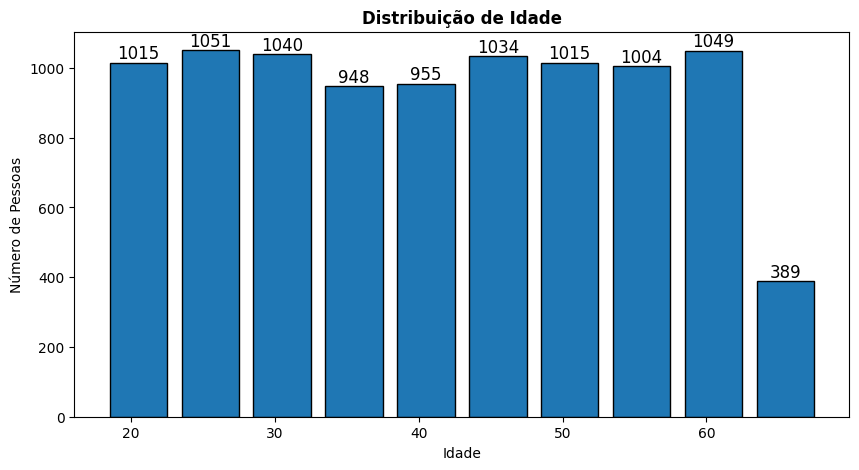

In [4]:
montar_grafico_histograma_idade(dados, 'Distribuição de Idade', 'Idade', 'Número de Pessoas')

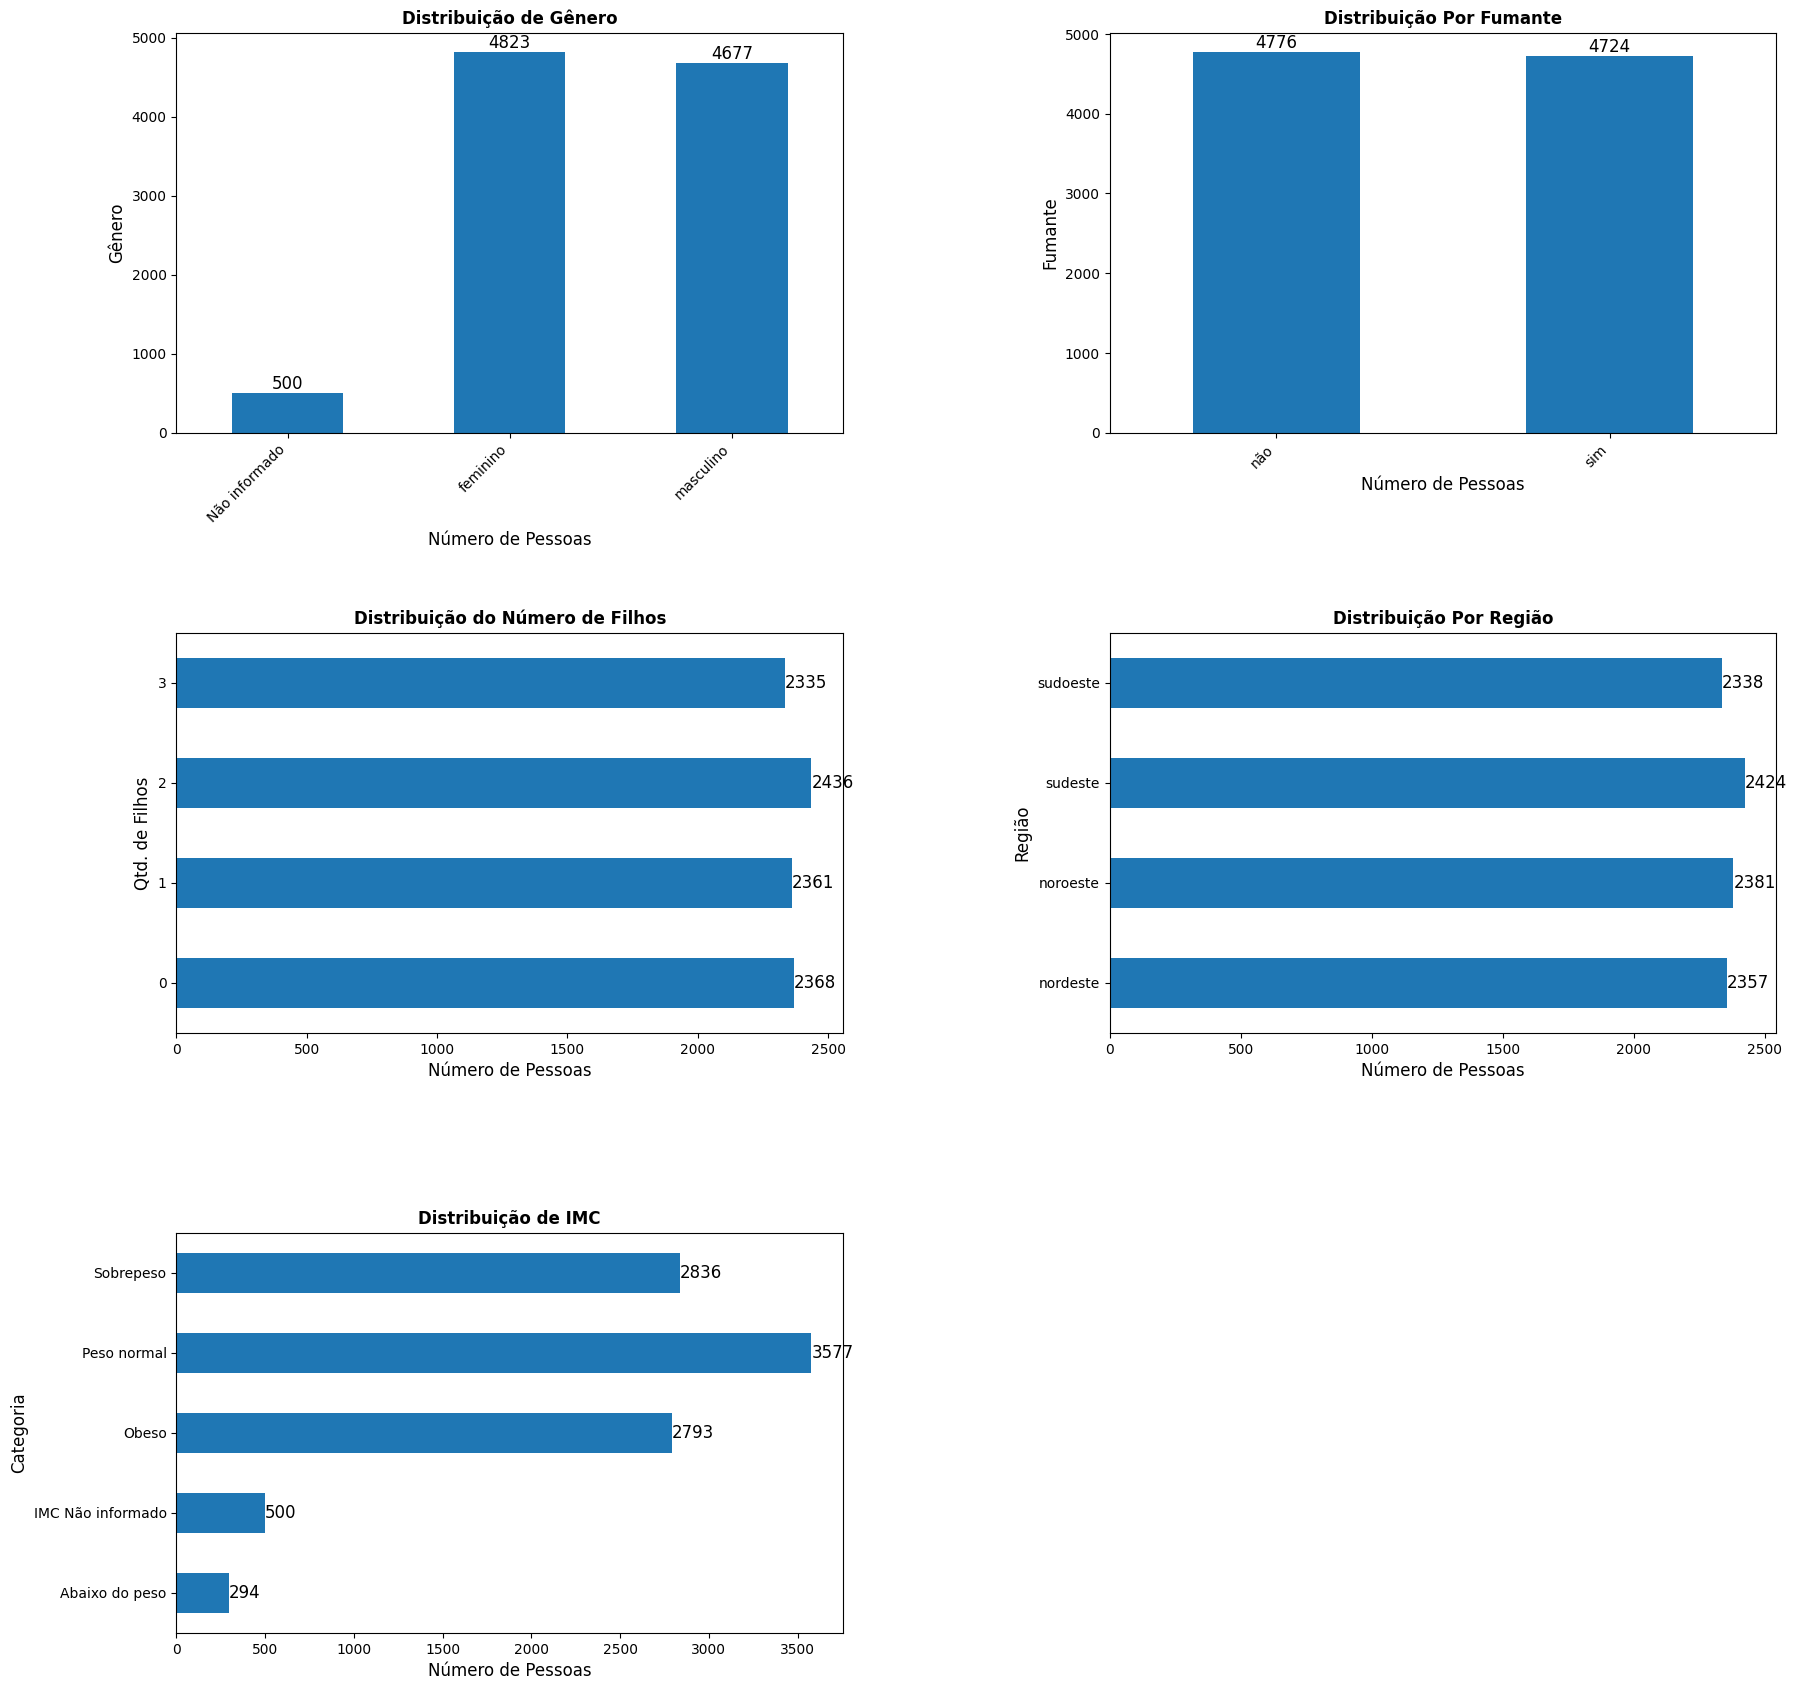

In [5]:
montar_graficos_visualizacao_inicial(dados)

**3. Separação dos Dados em Treino e Teste**

In [6]:
# Dividindo os dados em features (X) e target (y)
X = dados.drop(['Encargos','Gênero','Região','Categoria_IMC','Fumante_Numero'], axis=1)  # descartando colunas não necessárias para o teste
colunas_descartadas = dados[['Gênero','Região','Categoria_IMC']]

y = dados['Encargos']

# Codificando variáveis com LabelEncoder
label_encoder = LabelEncoder()
X['Fumante'] = label_encoder.fit_transform(X['Fumante'])

# Substituindo valores 'sim' e 'não' por 1 e 0 (comentando porque o resultado é o mesmo no LabelEncoder
#X['Fumante'] = X['Fumante'].map({'sim': 1, 'não': 0})

print("\nAmostra dos primeiros 20 registros:\n\n", X.head(20))


Amostra dos primeiros 20 registros:

     Idade    IMC  Filhos  Fumante
0      42  26.87       3        1
1      49  18.81       1        0
2      61  30.74       1        0
3      28  30.16       3        0
4      50  32.89       3        1
5      64  24.22       0        0
6      43  23.76       3        1
7      40  23.56       0        1
8      48  19.64       0        1
9      41  25.85       2        1
10     23  32.48       3        1
11     35    NaN       1        1
12     37  33.99       2        0
13     32  24.45       2        1
14     56  26.59       0        0
15     55  20.09       0        0
16     63  25.33       1        1
17     43  29.18       3        0
18     38  19.52       2        0
19     26  21.18       2        1


In [7]:
# Comentado todo bloco abaixo que usava OneHotEncoder, durante o desenvolvimento decidimos outras estratégias (mas mantivemos para estudos futuros)
# Dividir os dados em features (X) e target (y)
#X = dados.drop(['Encargos'], axis=1)  # descartando colunas não necessárias para o teste
#y = dados['Encargos']

# Codificar variáveis categóricas usando one-hot encoding
#colunas_codificadas_via_one_hot = ['Região']
#encoder = OneHotEncoder(drop='first')
#X_encoded = encoder.fit_transform(X[colunas_codificadas_via_one_hot])

# Concatenar features codificadas com as restantes
#X_encoded = pd.DataFrame(X_encoded.toarray(), columns=encoder.get_feature_names_out(colunas_codificadas_via_one_hot), index=X.index)
#X = pd.concat([X.drop(colunas_codificadas_via_one_hot, axis=1), X_encoded], axis=1)

# Codificar variáveis com LabelEncoder
#label_encoder = LabelEncoder()
#X['Gênero'] = label_encoder.fit_transform(X['Gênero'])
#X['Fumante'] = label_encoder.fit_transform(X['Fumante'])

#X['Categoria_IMC'] = label_encoder.fit_transform(X['Categoria_IMC'])

In [8]:
# Dividindo os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inserindo as colunas descartadas em X_train
for coluna in colunas_descartadas.columns:
    X_train.insert(loc=len(X_train.columns), column=coluna, value=colunas_descartadas[coluna])

# Inserindo as colunas descartadas em X_test
for coluna in colunas_descartadas.columns:
    X_test.insert(loc=len(X_test.columns), column=coluna, value=colunas_descartadas[coluna])

# Salvando o conjunto dos treinos
X_train.to_csv("../planilhas/2_dados_processados_treino.csv", index=False, encoding='latin1')

# Salvando o conjunto dos testes
X_test.to_csv("../planilhas/3_dados_processados_teste.csv", index=False, encoding='latin1')

# Salvando o conjunto dos alvos do treino
y_train.to_csv("../planilhas/4_dados_processados_treino_target.csv", index=False, encoding='latin1')

# Salvando o conjunto dos alvos do teste
y_test.to_csv("../planilhas/5_dados_processados_teste_target.csv", index=False, encoding='latin1')

**4. Análise Exploratória de Dados**

**Resumo Estatístico:**

In [9]:
print("\nResumo Estatístico sobre todos os dados:\n\n", dados.describe())
print('-' * terminal_width)
print("\nResumo Estatístico sobre a feature Gênero:\n\n", dados.groupby("Gênero").describe())
print('-' * terminal_width)
print("\nResumo Estatístico sobre a feature Categoria IMC:\n\n", dados.groupby("Categoria_IMC").describe())
print('-' * terminal_width)
print("\nResumo Estatístico sobre a feature Fumante:\n\n", dados.groupby("Fumante").describe())
print('-' * terminal_width)
print("\nResumo Estatístico sobre a feature Região:\n\n", dados.groupby("Região").describe())


Resumo Estatístico sobre todos os dados:

            Idade          IMC    Filhos  Fumante_Numero      Encargos
count     9500.0  9500.000000    9500.0     9500.000000  10000.000000
mean   40.970211    26.432680  1.498737        0.497263   4484.202431
std    13.639218     4.894098  1.113658        0.500019   1129.239383
min         18.0    18.000000       0.0        0.000000    705.050000
25%         29.0    22.200000       1.0        0.000000   3735.447500
50%         41.0    26.490000       2.0        0.000000   4532.815000
75%         53.0    30.640000       2.0        1.000000   5318.607500
max         64.0    35.000000       3.0        1.000000   7437.470000
--------------------------------------------------------------------------------------------------------------------------------------------------------------

Resumo Estatístico sobre a feature Gênero:

             Idade                                                         IMC  \
            count       mean        std 

In [10]:
# Imprindo dados mais específicos de algumas colunas
dados_especificos_coluna(dados, "Idade")
dados_especificos_coluna(dados, "IMC")
dados_especificos_coluna(dados, "Filhos")
dados_especificos_coluna(dados, "Encargos")


Na coluna Idade (Int64) a faixa dos dados está entre: 18 até 64.
O valor mais frequente na coluna Idade é: 18, que aparece 226 vezes.

Na coluna IMC (float64) a faixa dos dados está entre: 18.0 até 35.0.
O valor mais frequente na coluna IMC é: 28.47, que aparece 14 vezes.

Na coluna Filhos (Int64) a faixa dos dados está entre: 1 até 3.
O valor mais frequente na coluna Filhos é: 2, que aparece 2436 vezes.

Na coluna Encargos (float64) a faixa dos dados está entre: 705.05 até 7437.47.
O valor mais frequente na coluna Encargos é: 5500.25, que aparece 3 vezes.


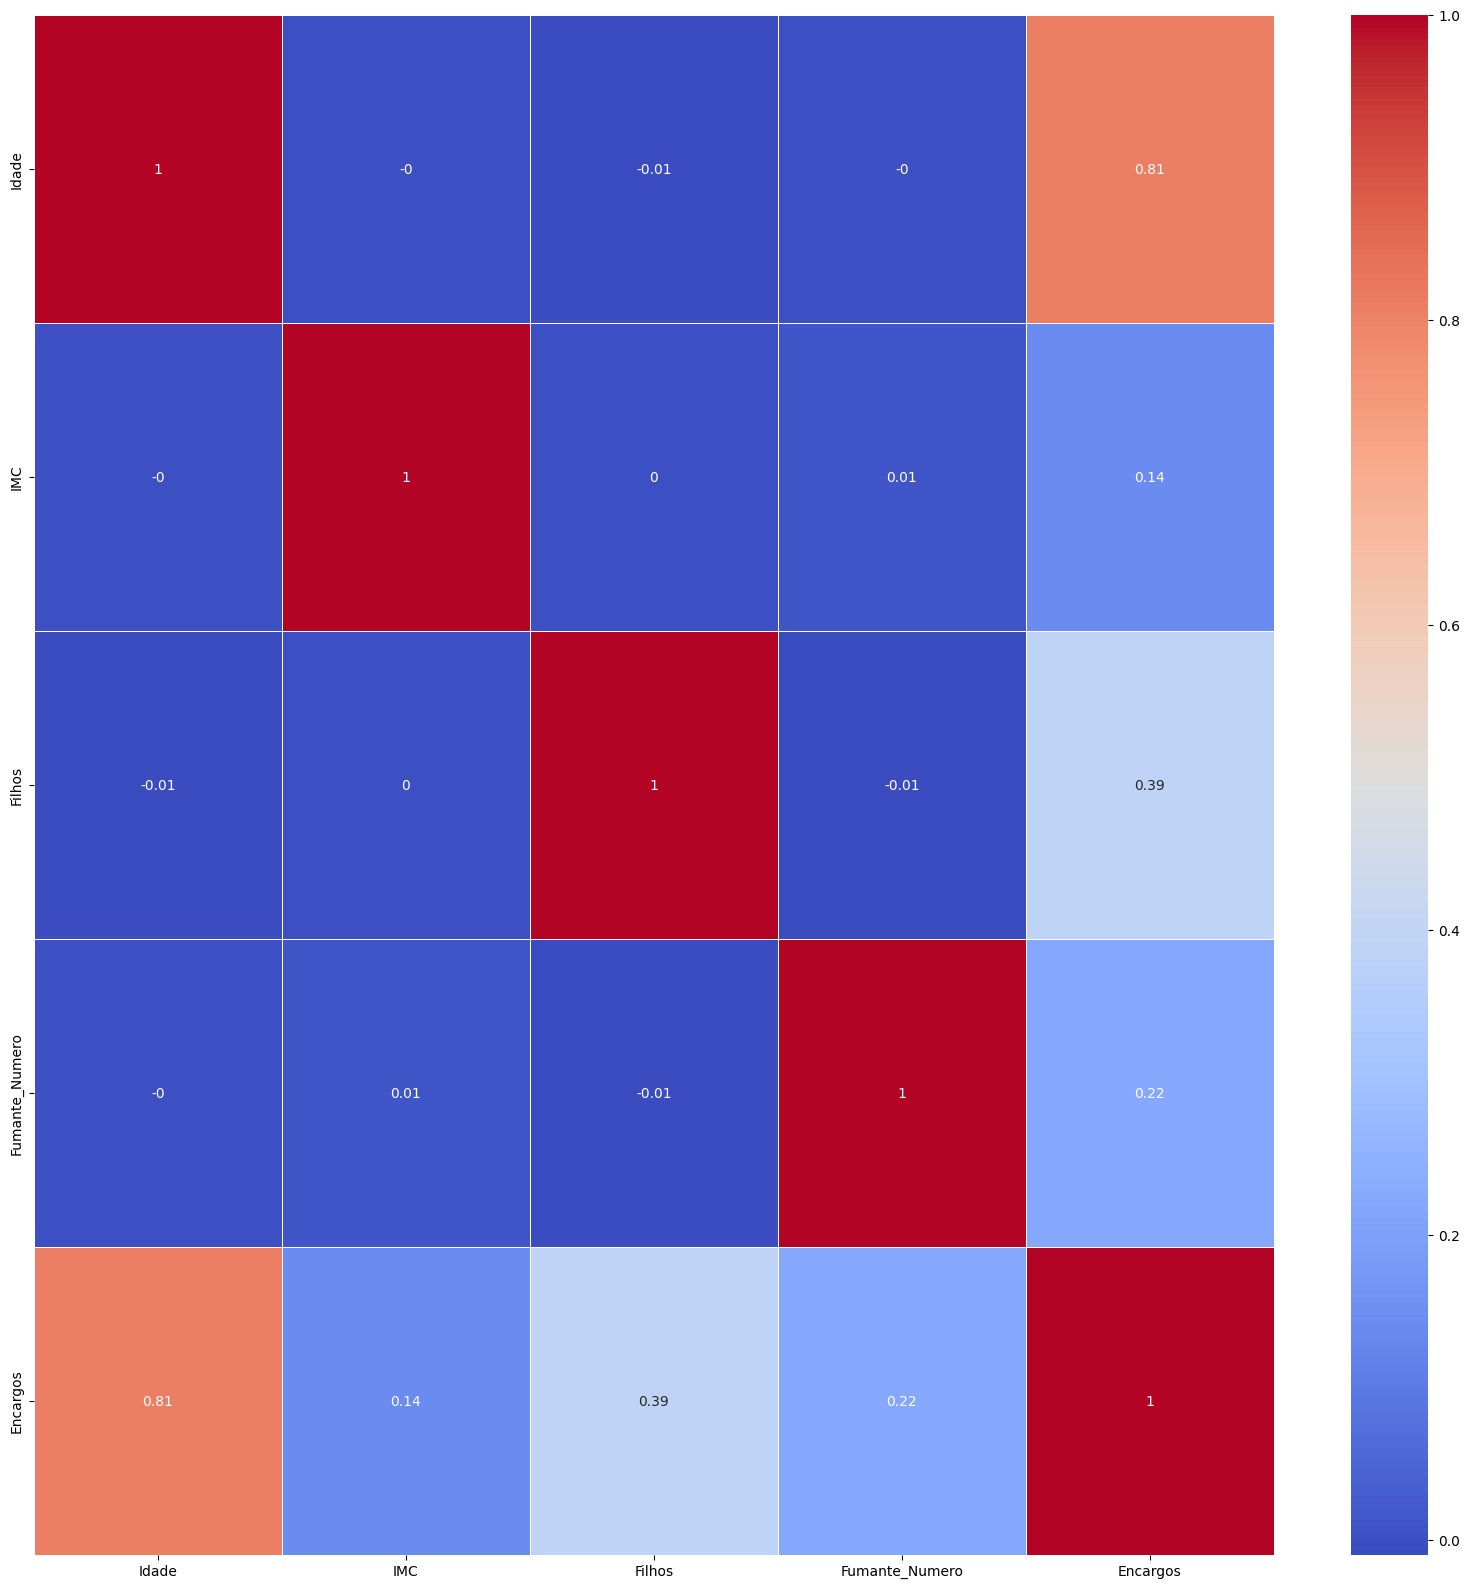

In [11]:
# Gerando gráfico de mapa de calor
numeric_columns = dados.select_dtypes(include='number')

correlation_matrix = numeric_columns.corr().round(2)

fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(data=correlation_matrix, annot=True, linewidths=.5, ax=ax, cmap="coolwarm")

# Removendo a coluna Fumante_Numero, não mais necessária (coluna Fumante mantida)
dados.drop(columns=['Fumante_Numero'], inplace=True)

**Identificação de Outliers:** 

<Axes: >

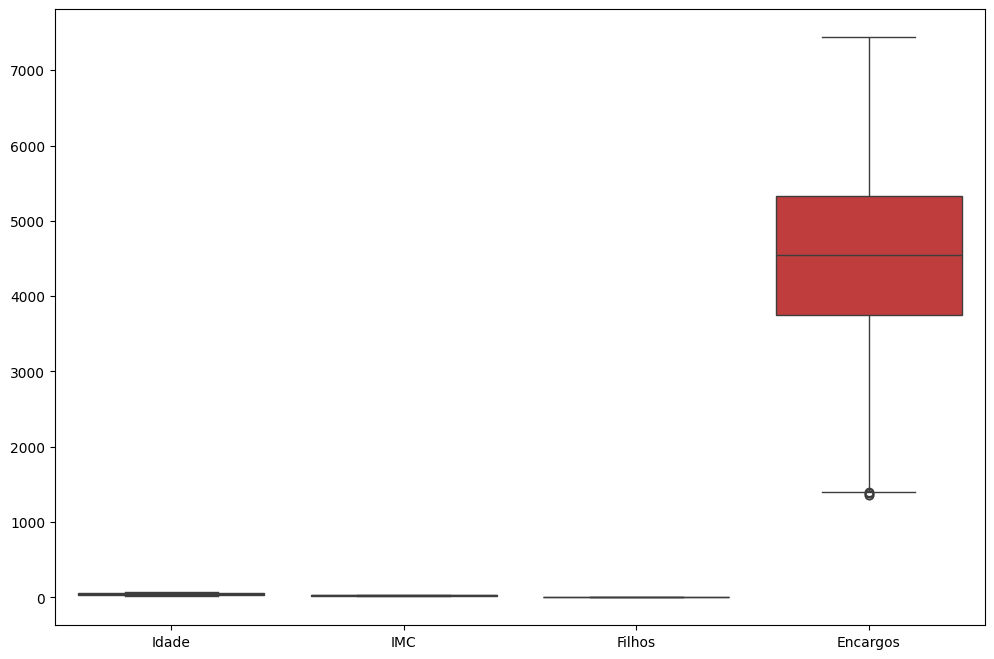

In [12]:
# Loop sobre as colunas
for coluna in dados.columns:
    # Quartis só funcionam em colunas numéricas
    if dados[coluna].dtype in ['int32','int64', 'float64']:
        # Calculando os quartis para a coluna atual
        quartis = dados[coluna].quantile([0.25, 0.75])
        
        # Calculando o intervalo interquartil (IQR)
        iqr = quartis[0.75] - quartis[0.25]
        
        # Definindo limites para identificar outliers
        limite_inferior = quartis[0.25] - 1.5 * iqr
        limite_superior = quartis[0.75] + 1.5 * iqr
        
        # Marcando os outliers como NaN
        dados['outlier_mask_' + coluna] = ((dados[coluna] < limite_inferior) | (dados[coluna] > limite_superior)).astype(int)
        dados[coluna] = dados[coluna].mask(dados['outlier_mask_' + coluna] == 1)

# Salvando os dados com os outliers
dados.to_csv("../planilhas/6_dados_com_outliers.csv", index=False, encoding='latin1')
        
# Removendo colunas de máscara de outliers
dados.drop(columns=[col for col in dados.columns if 'outlier_mask_' in col], inplace=True)

# Definindo o tamanho da figura para expandir a área do gráfico
fig, ax = plt.subplots(figsize=(12, 8))

# Plotando o boxplot
sns.boxplot(data=dados, ax=ax)

**Visualizações Gráficas:** Visualizações gráficas para entender a distribuição e relacionamentos entre as variáveis

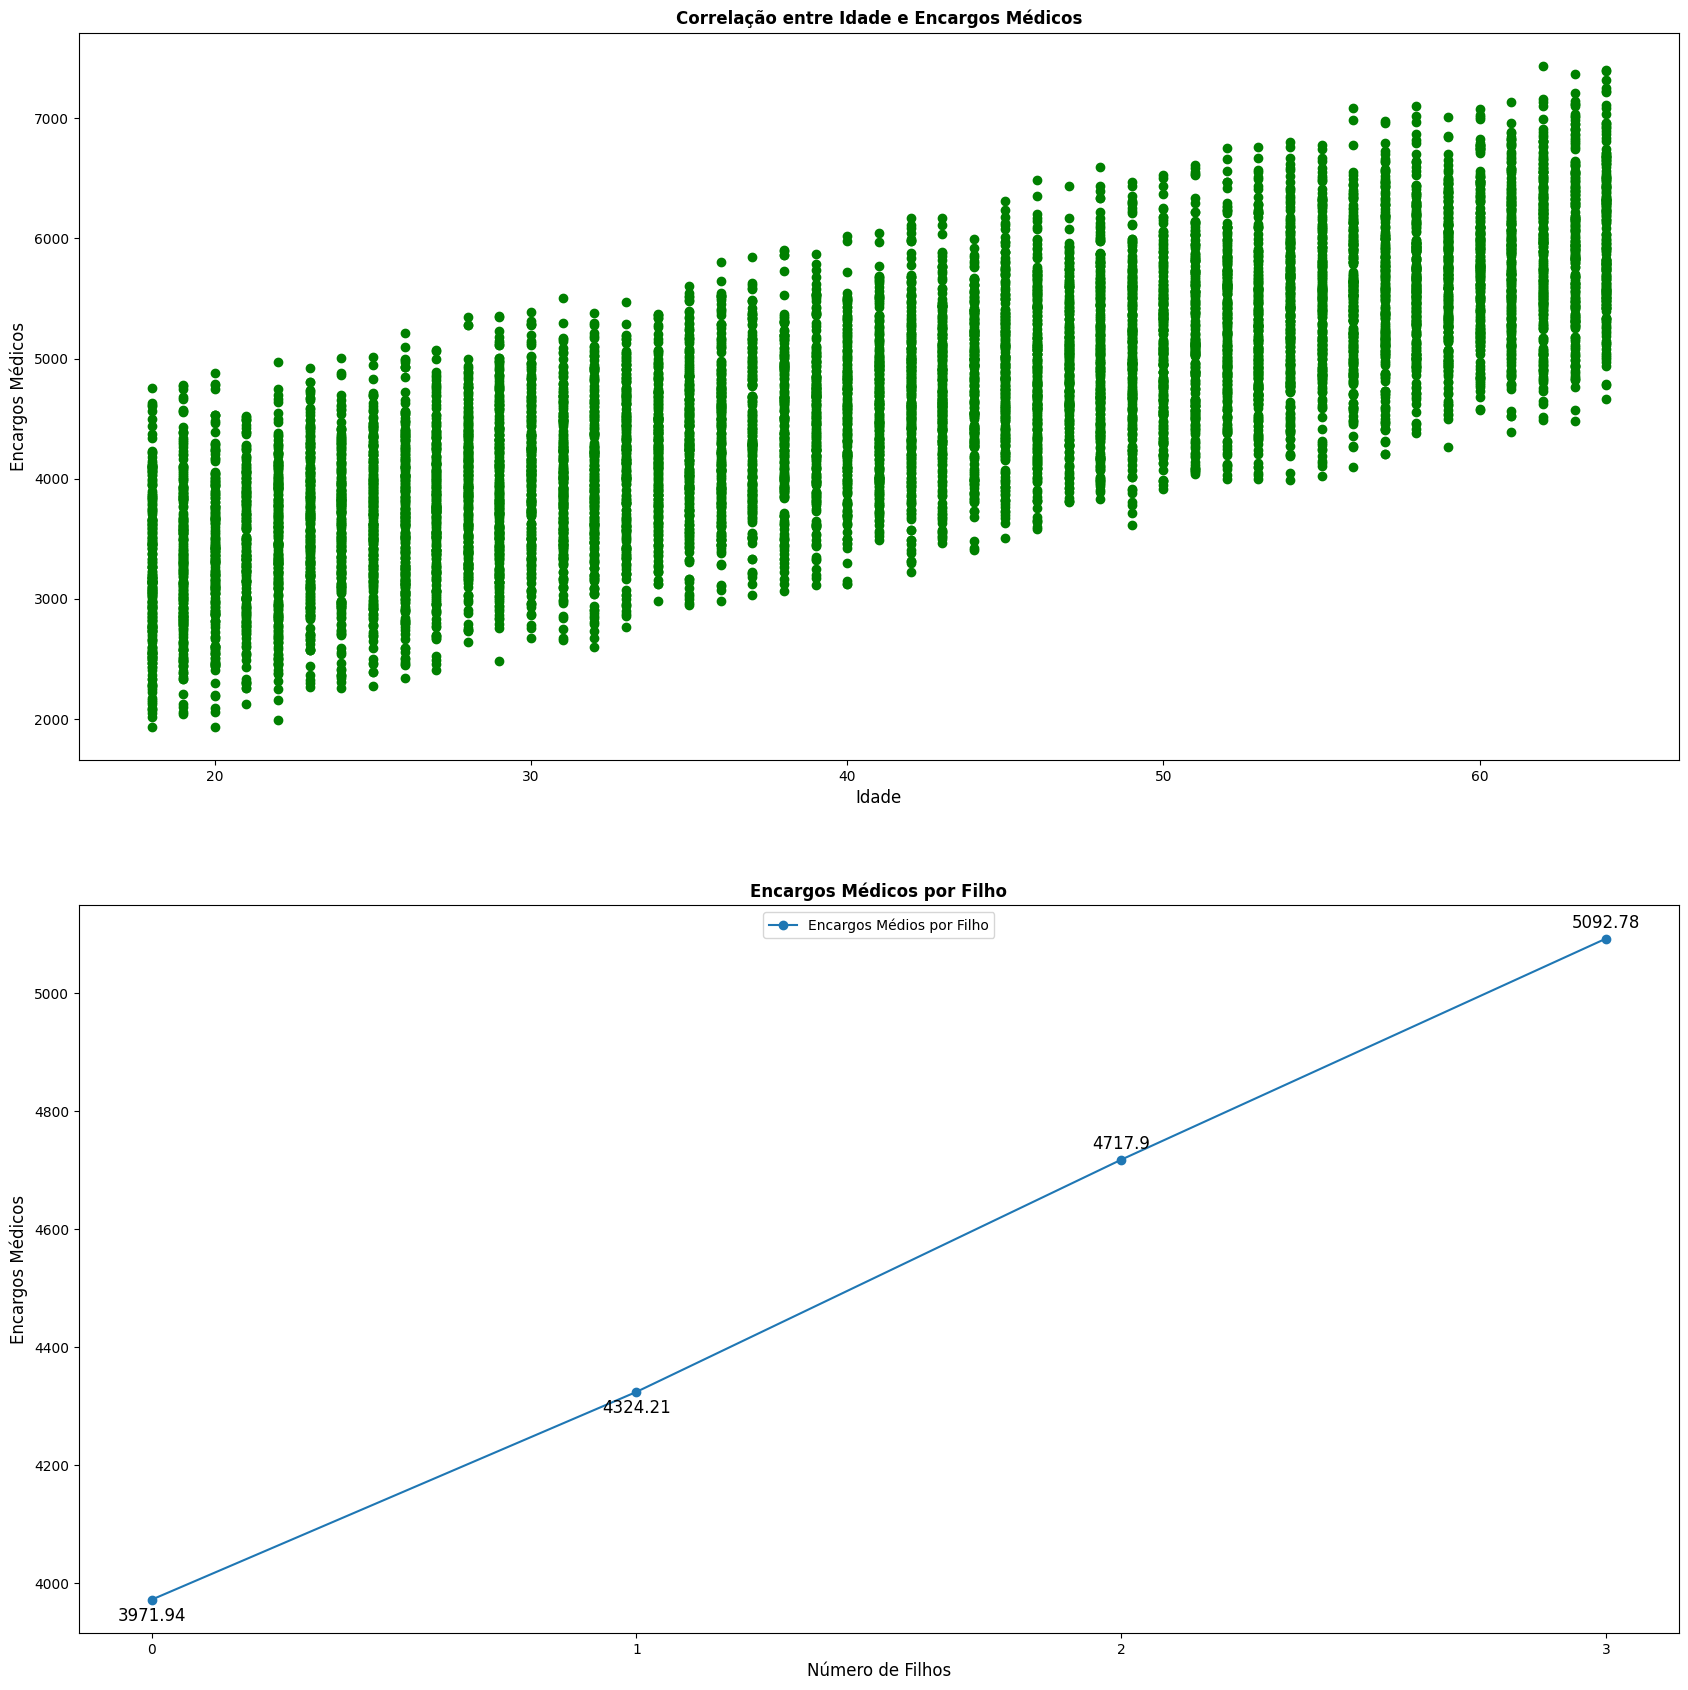

In [13]:
# Exibindo gráficos que demonstram a correlação entr features e o target (Encargos)
montar_graficos_relacionamento_encargos(dados)